In [1]:
import ee
ee.Initialize()

In [4]:
def ee_dem_encode(dem):
    """encoding in GEE"""
    vi = dem.add(10000).multiply(10)
    r = vi.divide(256 ** 2).mod(256).floor().rename('r')
    g = vi.divide(256 ** 1).mod(256).floor().rename('g')
    b = vi.divide(256 ** 0).mod(256).floor().rename('b')
    rgb256 = r.addBands(g).addBands(b)
    rgb01 = rgb256.divide(256)
    return rgb01  

def ee_dem_decode(demRgb):
    """demrgb is in range [0, 1]"""
    rgb256 = demRgb.float().multiply(256)
    r = rgb256.select(0)
    g = rgb256.select(1)
    b = rgb256.select(2)
    dem = r.multiply(256 * 256).add(g.multiply(256)).add(b).multiply(0.1).add(-10000)  
    return dem


def np_decode(demRgb):
    """demrgb is in range 0,1"""
    rgb01 = demRgb 
    rgb256 = rgb01 * 256
    r = np.floor(rgb256[..., 0])
    g = np.floor(rgb256[..., 1])
    b = np.floor(rgb256[..., 2])
    dem = -10000 + ((r * 256 * 256 + g * 256 + b) * 0.1)
    return dem
    

#  -10000 + ((r * 256 * 256 + g * 256 + b) * 0.1);
def np_encode(dem):
    """encoding and decoder"""
    vi = (dem + 10000) * 10
    r = np.floor((vi / 256 ** 2) % 256)
    g = np.floor((vi / 256 ** 1) % 256)
    b = np.floor((vi / 256 ** 0) % 256)
    rgb256 = np.dstack([r, g, b])
    rgb01 = rgb256 / 256.0
    return rgb01

def np_encode(dem):
    """encoding in numpy"""
    r = np.zeros(dem.shape)
    g = np.zeros(dem.shape)
    b = np.zeros(dem.shape)

    r += np.floor_divide((100000 + dem * 10), 65536)
    g += np.floor_divide((100000 + dem * 10), 256) - r * 256
    b += np.floor(100000 + dem * 10) - r * 65536 - g * 256
    rgb256 = np.dstack([r, g, b])
    rgb01 = rgb256 / 256.0
    return rgb01
    

def np_decode(demRgb):
    """decoding in numpy"""
    rgb01 = demRgb 
    rgb256 = rgb01 * 256
    r = rgb256[..., 0]
    g = rgb256[..., 1]
    b = rgb256[..., 2]
    dem = -10000 + ((r * 256 * 256 + g * 256 + b) * 0.1)
    return dem
    


In [5]:
# Create an TMS miniformat url so that gdal understands the tileset
template =  '''<GDAL_WMS>
    <Service name="TMS">
        <ServerUrl>{url}</ServerUrl>
        <SRS>EPSG:3857</SRS>
    </Service>
    <DataWindow>
        <UpperLeftX>-20037508.34</UpperLeftX>
        <UpperLeftY>20037508.34</UpperLeftY>
        <LowerRightX>20037508.34</LowerRightX>
        <LowerRightY>-20037508.34</LowerRightY>
        <TileLevel>18</TileLevel>
        <TileCountX>1</TileCountX>
        <TileCountY>1</TileCountY>
        <YOrigin>top</YOrigin>
    </DataWindow>
    <Projection>EPSG:3857</Projection>
    <BlockSizeX>256</BlockSizeX>
    <BlockSizeY>256</BlockSizeY>
    <BandsCount>3</BandsCount>
    <Cache>
        <Path>../.gdalwmscache</Path>
        <Extension>.png</Extension>
    </Cache>
</GDAL_WMS>
'''


def export_image(image, bounds, name):
    """download an image for a region and store it as name.png"""
    coords_web = bounds.transform('EPSG:3857', 1).coordinates().getInfo()

    tile_fetcher = image.getMapId()['tile_fetcher']
    url = tile_fetcher.url_format.format(x='${x}', y='${y}', z='${z}')
    
    lr = coords_web[0][1][0], coords_web[0][1][1]
    ul = coords_web[0][3][0], coords_web[0][3][1]

    width = lr[0] - ul[0]
    height = ul[1] - lr[1]
        
    with open(name + '.xml', 'w') as f:
        xml = template.format(url=url)
        f.write(xml)
        
    !gdal_translate {name}.xml -projwin {ul[0]} {ul[1]} {lr[0]} {lr[1]} -outsize 4096 4096 {name}.png

In [6]:
# create a non-geodetic area of interest
bounds = ee.Geometry.Polygon([[
          [-122.75548673853245, 38.0411041965202],
          [-122.75548673853245, 37.64853352930806],
          [-122.11690641626683, 37.64853352930806],
          [-122.11690641626683, 38.0411041965202]]], None, False)

In [94]:
# export DEM
dem = ee.Image("USGS/NED").visualize(**{"min": 0, "max": 700})
export_image(image=dem, name='dem', bounds=bounds)

Input file size is 67108864, 67108864
0...10...20...30...40...50...60...70...80...90...100 - done.


In [7]:
demRgb = ee_dem_encode(ee.Image('USGS/NED'))
# demRgb = ee_dem_encode(ee.Image(24.1))
export_image(image=demRgb, name='dem-rgb', bounds=bounds)

Input file size is 67108864, 67108864
0...10...20...30...40...50...60...70...80...90...100 - done.


0.0 0.99609375


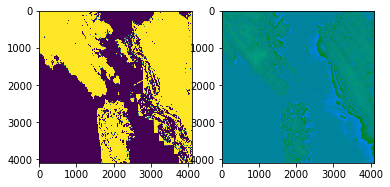

In [17]:
# check visually
import skimage.io
import matplotlib.pyplot as plt
import numpy as np
dem_rgb = skimage.io.imread('dem-rgb.png').astype('float') / 256.0
print(dem_rgb.min(), dem_rgb.max())
fig, axes = plt.subplots(ncols=2)
axes[0].imshow(dem_rgb)
dem = np_decode(dem_rgb)

axes[0].imshow(dem, vmin=0, vmax=700)
axes[1].imshow(dem_rgb)



In [13]:
#  check range
dem = np_decode(dem_rgb)

dem.min(), dem.max()

(-10000.0, -3472.0)

In [18]:
#  debug with one value
dem_rgb = np_encode(np.array([
    [24.1],
]))

dem = ee.Image(24.1)
dem_rgb = ee_dem_encode(dem)
dem = ee_dem_encode(dem_rgb)

